In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pickle

with open('zipcode.pickle', 'rb') as handle:
    zips = pickle.load(handle)

In [3]:
# %%writefile kmeans.py

import numpy as np

class Kmeans:
    """Customized K-means class to use alternative cost functions."""
   
    def __init__(self, data, distance_function):
        self._distance_function = distance_function
        self.nPoints = len(data)
        self.__initDataMatrix(data)
        
        
    def __initDataMatrix(self, data):
        self._index = {}
        self._matrix = np.zeros((self.nPoints , 2))
        count = 0
        for key, value in data.items():
            self._index[key] = count
            self._matrix[count,:] = value
            count += 1
       
        
    def startK(self, n, method = 'K++'):
        self._K = None
        if(method == 'random'):
            self.__randomStart(n)
       
        elif(method == 'K++'):
            self.__ppStart(n)
       
        return self._K
    
    
    def __randomStart(self, n):
        self._K = np.zeros((n, 2))
        for i in range(n):
            row = np.random.randint(low=0, high=self.nPoints)       
            self._K[i,:] = (self._matrix[row,:])
    
    
    def __ppStart(self, n):
        p0 = self._matrix[np.random.randint(low=0, high=self.nPoints),:]
        self._K = np.matrix([p0])
        
        for k in range(1, n):            
            distVec = self.distClosestPoint(self._K)[:,1]
        
            distVec = np.power(distVec, 2)
            probVec = distVec / np.sum(distVec)
            cumProbVec = np.cumsum(probVec)
        
            r = np.random.rand()
        
            for j,p in enumerate(cumProbVec):
                if r < p:
                    i = j
                    break
            self._K = np.append(self._K, [self._matrix[i,:]], axis=0)
            
            
    def fit(self, iterations = 1000):
        for i in range(iterations):
            lastK = self._K
            distVec, self._K = self.updateK()
            
            if(np.array_equal(lastK, self._K)):
                return i, distVec, self._K
            
        return i, distVec, self._K
            
            
    def updateK(self):
        distVec = self.distClosestPoint(self._K)
        
        updK = np.zeros_like(self._K)
        
        nPoints = [0] * len(self._K)
        
        for i in range(self.nPoints):
            k = int(distVec[i,0])
            updK[k,:] += self._matrix[i,:]
            nPoints[k] += 1            
        
        for i in range(len(self._K)):
            updK[i,:] /= nPoints[i]            
        
        return distVec, updK
        
        
    def vecMatDistancePoint(self, point):
        return np.apply_along_axis(self.pingCost, 1, self._matrix, point)        
        
    
    def pingCost(self, p1, p2):
        return self._distance_function(p1, np.reshape(p2,2))
    
    
    ''' 
        Returns a matrix where first column is the closest point and seconde column is 
        the distance and each row is respective to the same row in the data maxtrix
    '''
    def distClosestPoint(self, pointList):
        n = len(pointList)
        mat = np.zeros((self.nPoints, n))
        
        for i in range(n):
            distVec = self.vecMatDistancePoint(pointList[i])
            mat[:,i] = distVec
            
        out = np.zeros((self.nPoints, 2))
        
        # TO DO: maybe find a way to iterate only once and get index and distance
        out[:,0] = np.argmin(mat, axis=1)
        out[:,1] = np.amin(mat, axis=1)
        return out
    
    
    @property
    def matrix(self):
        return self._matrix
    
    @property
    def K(self):
        return self._K
    
    def getPoints(self, key):
        return self._matrix[self._index[key]]
       

In [4]:
# %%writefile cost_functions.py

from scipy.spatial import distance
import math

def euclidean(p1, p2):
    return distance.euclidean(p1, p2)

def distanceHaversine(p1, p2):
    p2 = np.squeeze(np.asarray(p2)) # Transform matrix 1,2 into an array with coord
    
    lat1 = p1[1]
    lng1 = p1[0]
    lat2 = p2[1]
    lng2 = p2[0]
   
    earthRadius = 3959
   
    lat1Rad = lat1 * math.pi/180
    lat2Rad = lat2 * math.pi/180
   
    Dlat = (lat2 - lat1) * math.pi/180
    Dlng = (lng2 - lng1) * math.pi/180
   
    a = pow(math.sin(Dlat/2), 2) + math.cos(lat1Rad) * math.cos(lat2Rad) * pow(math.sin(Dlng/2), 2)
   
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
   
    return (c * earthRadius)

In [5]:
test = Kmeans(zips, distanceHaversine)

t = test.startK(4)

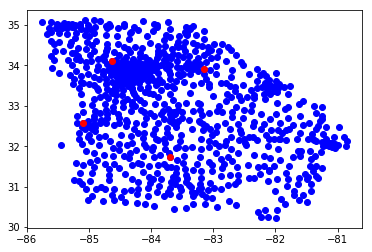

In [6]:
m = test.matrix
plt.plot(m[:, 0].flatten(),m[:, 1].flatten(), 'bo', t[:, 0].flatten(),t[:, 1].flatten(), 'ro')

In [7]:
ite, distVec, tf = test.fit()

In [8]:
# %%writefile util.py

# TO DO: This function needs to be improved right now is iterating one time for each cluster

def plotResult(m, k, distVec):
    cluster = [[],[]]

    styles = ['bo', 'go', 'co', 'mo', 'yo', 'ko', 'ro', 'bs', 'gs', 'cs', 'ms', 'ys', 'ks', 'rs']

    for j in range(len(k)):
        for i in range(len(m)):
            if(distVec[i] == j):
                cluster[0].append(m[i,0])
                cluster[1].append(m[i,1])

            plt.plot(cluster[0], cluster[1], styles[j])
            cluster = [[],[]]

    plt.plot(k[:, 0].flatten(),k[:, 1].flatten(), 'r^')

Iterations:  10
AVG distance:  49.3901637667


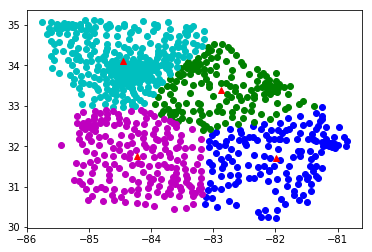

In [9]:
print("Iterations: ", ite)
print("AVG distance: ", np.mean(distVec[:,1]))

plotResult(m, tf, distVec[:,0])